In [1]:
import os

if os.getcwd().endswith('notebooks'):
    os.chdir('..')
print(os.getcwd())

/home/cmcouto-silva/Projects/github/gee-assessment


In [2]:
import pandas as pd
import geopandas as gpd

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import matplotlib.ticker as ticker

In [3]:
# See all possibilites at https://matplotlib.org/stable/users/explain/customizing.html
sns.set_theme(
    context='talk', style='ticks', palette='viridis', font_scale=.8,
    rc={
      'figure.figsize': (15,6),
      'font.weight': 'regular', 'axes.labelpad': 15, 'axes.titlepad': 30,
      'ytick.labelsize': 'small', 'xtick.labelsize': 'small',
      'axes.grid':True, 'grid.alpha':.2
    }
)

# Define common colors for biomes
biome_colors = {
    'Amazônia': '#004B00',      
    'Caatinga': '#DAA520',      
    'Cerrado': '#F4A460',       
    'Mata Atlântica': '#32CD32', 
    'Pampa': '#90EE90',         
    'Pantanal': '#6B8E23'       
}

In [4]:
def human_readable_number(x, pos):
    """Convert number to K (thousands) or M (millions)"""
    if x >= 1e6:
        return f'{x/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x/1e3:.0f}K'
    else:
        return f'{x:.0f}'


def compute_crop_statistics(df, crop_var, loss_var):
    df_crop = (
        df.query('variable==@crop_var')
        .drop(columns=['geometry','variable'])
        .rename(columns={
            'value': 'crop_ha',
            'value_normalized': 'crop_total_pct'
        })
    )

    df_loss = (
        df.query('variable==@loss_var')
        .loc[:,['Bioma','year','value']]
        .rename(columns={'value':'forest_loss'})
    )

    df_crop_stats = (
        df_crop.merge(df_loss)
        .assign(crop_loss_pct = lambda x: x.crop_ha / x.forest_loss)
        .drop(columns='forest_loss')
        .set_index(['Bioma','year'])
        .sort_index()
    )

    return df_crop_stats

In [5]:
df = gpd.read_file('data/br_deforestation_biome.geojson')

mapper = {
    'Amaz�nia':'Amazônia',
    'Mata Atl�ntica': 'Mata Atlântica'
}

df['Bioma'] = df['Bioma'].replace(mapper)

In [6]:
id_vars = ['Bioma','area_Mha','area_ha','geometry']
value_vars = df.columns[df.columns.str[-4:].str.isdigit()].tolist()

df_long = (
    df
    .melt(id_vars=id_vars, value_vars=value_vars)
    .assign(
        value_normalized = lambda x: x.value / x.area_ha,
        year = lambda x: x.variable.str[-4:].astype(int),
        variable = lambda x: x.variable.str[:-5],
    )
)

df_mb_deforestation = df_long.query('variable=="MB_deforestation"')
df_gfw_forest_loss = df_long.query('variable=="GFW_forest_loss"')

In [7]:
df_gfw_crop_stats = compute_crop_statistics(df_long, crop_var='GFW_crop_forest_loss', loss_var='GFW_forest_loss').reset_index()
df_mp_crop_stats = compute_crop_statistics(df_long, crop_var='MB_crop_deforestation', loss_var='MB_deforestation').reset_index()

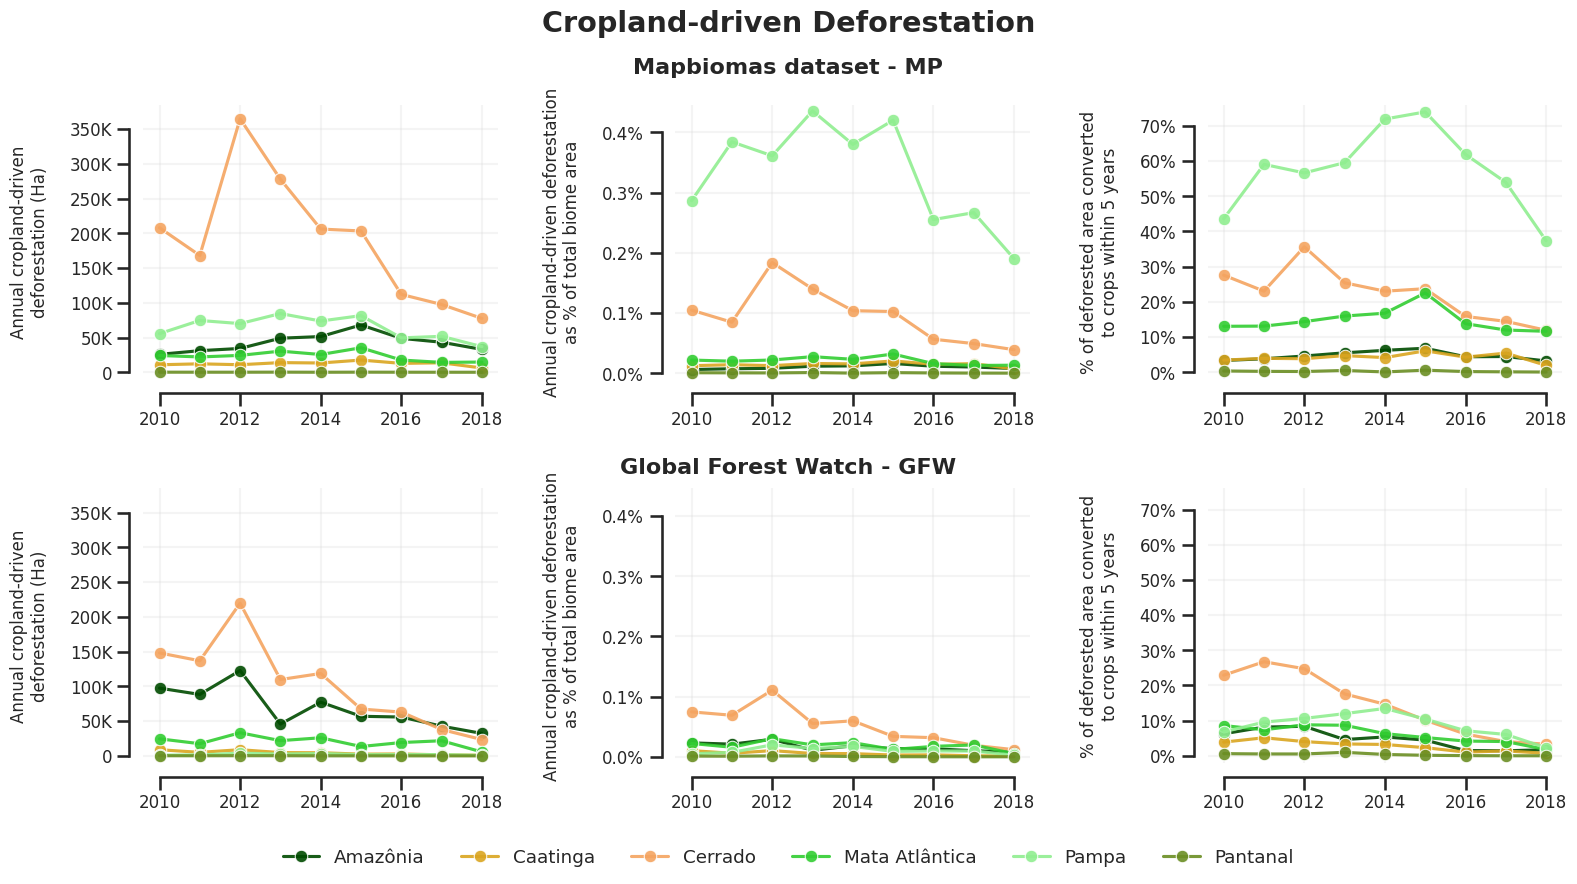

In [8]:
fig,axes = plt.subplots(nrows=2, ncols=3, figsize=(16,8))

df_crop_concat = pd.concat([df_mp_crop_stats, df_gfw_crop_stats])
crop_ha_min, crop_ha_max = df_crop_concat.crop_ha.agg(['min','max'])
crop_total_pct_min, crop_total_pct_max = df_crop_concat.crop_total_pct.agg(['min','max'])
crop_loss_pct_min, crop_loss_pct_max = df_crop_concat.crop_loss_pct.agg(['min','max'])

sns.lineplot(data=df_mp_crop_stats, x='year', y='crop_ha', hue='Bioma', marker='o', palette=biome_colors, ax=axes[0,0], legend=True, alpha=.9)
sns.lineplot(data=df_mp_crop_stats, x='year', y='crop_total_pct', hue='Bioma', marker='o', palette=biome_colors, ax=axes[0,1], legend=False, alpha=.9)
sns.lineplot(data=df_mp_crop_stats, x='year', y='crop_loss_pct', hue='Bioma', marker='o', palette=biome_colors, ax=axes[0,2], legend=False, alpha=.9)

sns.lineplot(data=df_gfw_crop_stats, x='year', y='crop_ha', hue='Bioma', marker='o', palette=biome_colors, ax=axes[1,0], legend=False, alpha=.9)
sns.lineplot(data=df_gfw_crop_stats, x='year', y='crop_total_pct', hue='Bioma', marker='o', palette=biome_colors, ax=axes[1,1], legend=False, alpha=.9)
sns.lineplot(data=df_gfw_crop_stats, x='year', y='crop_loss_pct', hue='Bioma', marker='o', palette=biome_colors, ax=axes[1,2], legend=False, alpha=.9)

plt.suptitle('Cropland-driven Deforestation', weight='bold', size='x-large', y=1.03)

fig.text(0.5, 0.95, 'Mapbiomas dataset - MP', weight='bold', ha='center', fontsize=16)
fig.text(0.5, 0.45, 'Global Forest Watch - GFW', weight='bold', ha='center', fontsize=16)

for ax in axes.flatten():
    ax.set_xlabel(None)

for i in (0,1):
    axes[i,0].set_ylabel('Annual cropland-driven\ndeforestation (Ha)', size='small')
    axes[i,1].set_ylabel('Annual cropland-driven deforestation\nas % of total biome area', size='small')
    axes[i,2].set_ylabel('% of deforested area converted\nto crops within 5 years', size='small')

    axes[i,0].set_ylim(-10000, top=crop_ha_max+20_000)
    axes[i,1].set_ylim(-0.0001,top=crop_total_pct_max+0.0001)
    axes[i,2].set_ylim(-0.02, top=crop_loss_pct_max+0.02)

    axes[i,0].yaxis.set_major_formatter(ticker.FuncFormatter(human_readable_number))
    axes[i, 1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
    axes[i, 2].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

handles, labels = axes[0,0].get_legend_handles_labels()
axes[0,0].get_legend().remove()
fig.legend(handles, labels, loc='center', frameon=False,  bbox_to_anchor=(0.5, -0.03), ncol=len(biome_colors))

sns.despine(trim=True, offset=10)
plt.tight_layout(h_pad=3, w_pad=2)

plt.savefig('reports/figures/cropland_driven_deforestation.png', dpi=500, bbox_inches='tight')
plt.show()

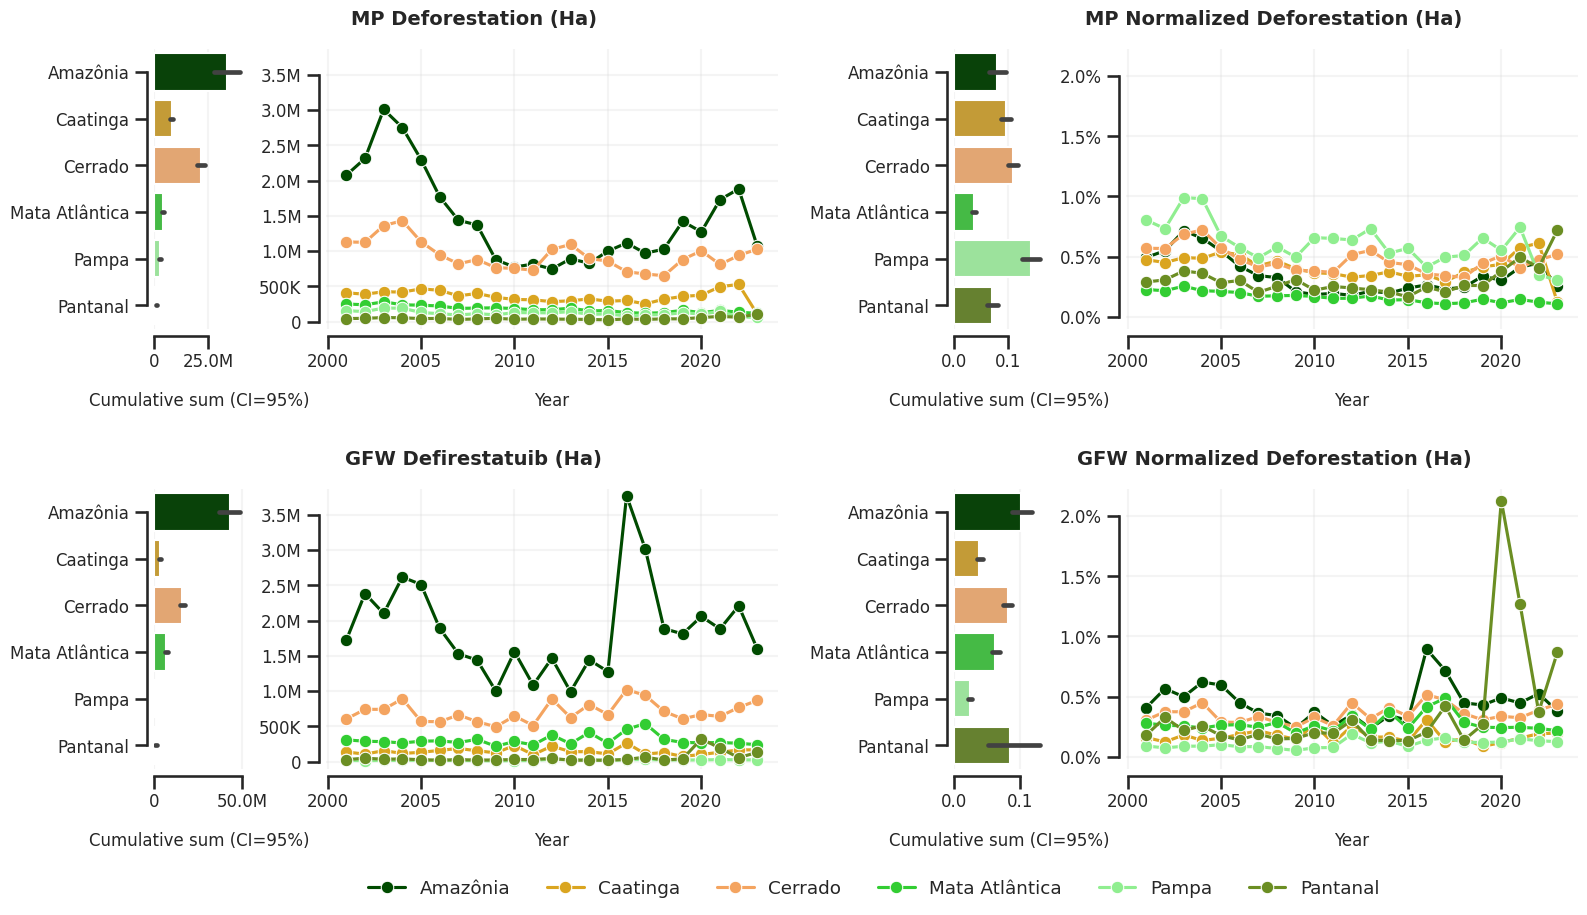

In [9]:
# Create figure
fig = plt.figure(figsize=(16, 8))

value_min, value_max = pd.concat([df_mb_deforestation,df_gfw_forest_loss]).value.agg(['min','max'])
value_min = -100_000
value_max += 100_000

value_norm_min, value_norm_max = pd.concat([df_mb_deforestation,df_gfw_forest_loss]).value_normalized.agg(['min','max'])
value_norm_min = 0 - 0.001
value_norm_max += 0.001

# Create separate GridSpecs for left and right sides of each row
gs_topleft = gridspec.GridSpec(1, 2, width_ratios=[0.4, 2], wspace=0.3, 
                              left=0.05, right=0.44,
                              top=0.95, bottom=0.60)

gs_topright = gridspec.GridSpec(1, 2, width_ratios=[0.4, 2], wspace=0.3,
                               left=0.55, right=0.94,
                               top=0.95, bottom=0.60)

gs_bottomleft = gridspec.GridSpec(1, 2, width_ratios=[0.4, 2], wspace=0.3,
                                 left=0.05, right=0.44,
                                 top=0.40, bottom=0.05)

gs_bottomright = gridspec.GridSpec(1, 2, width_ratios=[0.4, 2], wspace=0.3,
                                 left=0.55, right=0.94,
                                 top=0.4, bottom=0.05)

# Create axes
ax1 = fig.add_subplot(gs_topleft[0])      # Top row, first bar plot
ax2 = fig.add_subplot(gs_topleft[1])      # Top row, first line plot
ax3 = fig.add_subplot(gs_topright[0])     # Top row, second bar plot
ax4 = fig.add_subplot(gs_topright[1])     # Top row, second line plot
ax5 = fig.add_subplot(gs_bottomleft[0])   # Bottom row, first bar plot
ax6 = fig.add_subplot(gs_bottomleft[1])   # Bottom row, first line plot
ax7 = fig.add_subplot(gs_bottomright[0])  # Bottom row, second bar plot
ax8 = fig.add_subplot(gs_bottomright[1])  # Bottom row, second line plot

# Plot MP data (first row)
sns.barplot(data=df_mb_deforestation, y='Bioma', x='value', hue='Bioma', 
            estimator='sum', ax=ax1, palette=biome_colors, legend=False)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(human_readable_number))

sns.lineplot(data=df_mb_deforestation, x='year', y='value', hue='Bioma', 
             palette=biome_colors, marker='o', ax=ax2, legend=False)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(human_readable_number))
ax2.set_ylim(value_min, value_max)

sns.barplot(data=df_mb_deforestation, y='Bioma', x='value_normalized', hue='Bioma', 
            estimator='sum', ax=ax3, palette=biome_colors, legend=False)
sns.lineplot(data=df_mb_deforestation, x='year', y='value_normalized', hue='Bioma', 
             palette=biome_colors, marker='o', ax=ax4, legend=False)
ax4.set_ylim(value_norm_min, value_norm_max)
ax4.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))

# Plot GFW data (second row)
sns.barplot(data=df_gfw_forest_loss, y='Bioma', x='value', hue='Bioma', 
            estimator='sum', ax=ax5, palette=biome_colors, legend=False)
ax5.xaxis.set_major_formatter(ticker.FuncFormatter(human_readable_number))

sns.lineplot(data=df_gfw_forest_loss, x='year', y='value', hue='Bioma', 
             palette=biome_colors, marker='o', ax=ax6, legend=False)
ax6.yaxis.set_major_formatter(ticker.FuncFormatter(human_readable_number))
ax6.set_ylim(value_min, value_max)

sns.barplot(data=df_gfw_forest_loss, y='Bioma', x='value_normalized', hue='Bioma', 
            estimator='sum', ax=ax7, palette=biome_colors, legend=False)
sns.lineplot(data=df_gfw_forest_loss, x='year', y='value_normalized', hue='Bioma', 
             palette=biome_colors, marker='o', ax=ax8)
ax8.set_ylim(value_norm_min, value_norm_max)
ax8.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))

# Remove redundant labels
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
for ax in axes:
    ax.set(ylabel=None)

# Add descriptions
for ax in [ax1, ax3, ax5, ax7]:
    ax.set_xlabel('Cumulative sum (CI=95%)', size='small')
for ax in [ax2, ax4, ax6, ax8]:
    ax.set_xlabel('Year', size='small')

# Add titles
fig.text(0.25, 0.98, 'MP Deforestation (Ha)', weight='bold', ha='center', fontsize=14)
fig.text(0.75, 0.98, 'MP Normalized Deforestation (Ha)', weight='bold', ha='center', fontsize=14)
fig.text(0.25, 0.43, 'GFW Defirestatuib (Ha)', weight='bold', ha='center', fontsize=14)
fig.text(0.75, 0.43, 'GFW Normalized Deforestation (Ha)', weight='bold', ha='center', fontsize=14)

# Get legend from the last plot and place it at the bottom
handles, labels = ax8.get_legend_handles_labels()
ax8.get_legend().remove()
fig.legend(handles, labels, loc='center', frameon=False, 
           bbox_to_anchor=(0.5, -0.1), ncol=len(biome_colors))

sns.despine(trim=True, offset=5)

plt.savefig('reports/figures/deforestation_methods_comparison.png', dpi=500, bbox_inches='tight')
plt.show()